In [1]:
# Imports
import os
import random
import warnings

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.random import set_seed

2025-09-12 23:54:48.850903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 23:54:48.918131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757732088.956284  129610 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757732088.966238  129610 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757732089.021934  129610 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Funciones varias

def set_all_seeds(seed_value: int):
    # enable_op_determinism()
    tf.config.experimental.enable_op_determinism()
    set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# 1. GRU Unidireccional
def create_gru():
    model = Sequential([
        Input(shape=(WINDOW_SIZE, 1)),
        GRU(neuron_units, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function)
    model.summary()

    return model


# 2. LSTM Unidireccional
def create_lstm():
    model = Sequential([
        Input(shape=(WINDOW_SIZE, 1)),
        LSTM(neuron_units, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function)
    model.summary()
    
    return model


def train_model(model: Sequential, train_epochs: int, train_verbose: int):
    early_stopping = EarlyStopping(
        patience=max(1, int(train_epochs / 2)),
        min_delta=0.01,
        verbose=train_verbose,
        monitor='val_loss',
        restore_best_weights=True,
        mode='min'
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,
        patience=max(1, int(train_epochs / 4)),
        min_lr=1e-7,
        verbose=train_verbose,
        min_delta=0.01
    )

    return model.fit(
        X_train, y_train,
        epochs=train_epochs,
        batch_size=32,
        verbose=train_verbose,
        validation_split=0.2,
        shuffle=False,
        callbacks=[early_stopping, reduce_lr]
    )

def calculate_metrics(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"\n{model_name}:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

In [3]:
# Setup
set_all_seeds(1234)

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

In [4]:
# Preparacion de los Datos

# Cargar datos
df = pd.read_csv('QQQ_split_adj.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Verificar datos faltantes
if df['close'].isnull().any():
    print("⚠️ Datos faltantes detectados, aplicando interpolación...")
    df['close'] = df['close'].interpolate()

print(f"Dataset: {len(df)} filas desde {df['date'].min()} hasta {df['date'].max()}")

# Dividir dataset: primeros 20 años para entrenamiento
train_end_date = df['date'].min() + pd.DateOffset(years=20)
train_data = df[df['date'] <= train_end_date].copy()
test_data = df[df['date'] > train_end_date].copy()

print(f"Entrenamiento: {len(train_data)} días hasta {train_end_date.date()}")
print(f"Validación: {len(test_data)} días desde {test_data['date'].min().date()}")

Dataset: 6316 filas desde 1999-03-10 00:00:00 hasta 2024-04-15 00:00:00
Entrenamiento: 5032 días hasta 2019-03-10
Validación: 1284 días desde 2019-03-11


In [5]:
# Normalizacion y Creacion de Secuencias


# Normalizar datos
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
train_scaled = scaler.fit_transform(train_data[['close']])
test_scaled = scaler.transform(test_data[['close']])


# Crear secuencias de Entrenamiento
WINDOW_SIZE = 252
# loss_function = 'mse'
loss_function = 'mape'
X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)

# Verificar y ajustar forma de datos para RNNs (3D: samples, timesteps, features)
if len(X_train.shape) == 2:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(f"Forma de entrenamiento: X={X_train.shape}, y={y_train.shape}")


Forma de entrenamiento: X=(4780, 252, 1), y=(4780, 1)



ANÁLISIS EXPLORATORIO DE PRECIOS (CLOSE)
Observaciones: 6316
Media: 116.37
P25: 42.09
P50 (Mediana): 67.06
P75: 156.20
P90: 309.44
Rango Intercuartílico (IQR): 114.11
Mínimo: 20.06
Máximo: 446.38
Desviación Estándar: 105.23
Asimetría (Skewness): 1.43
Curtosis: 0.90


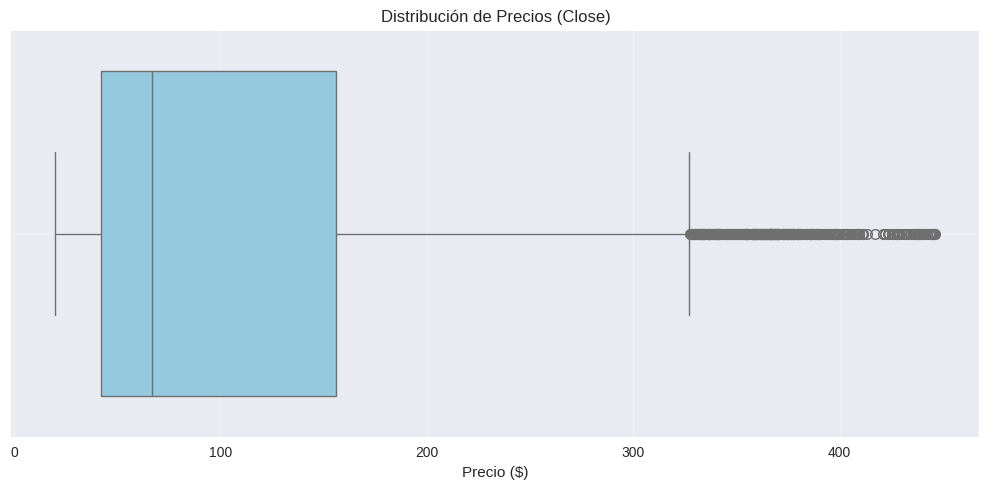

In [6]:
# =============================================================================
# ANÁLISIS EXPLORATORIO DE LOS DATOS
# =============================================================================

# Seleccionamos la serie de precios
close_prices = df['close']

# Estadísticas solicitadas
mean_val = close_prices.mean()
p25 = close_prices.quantile(0.25)
p50 = close_prices.quantile(0.50)
p75 = close_prices.quantile(0.75)
p90 = close_prices.quantile(0.90)
iqr = p75 - p25

# Estadísticas adicionales
min_val = close_prices.min()
max_val = close_prices.max()
std_val = close_prices.std()
skewness = close_prices.skew()
kurtosis = close_prices.kurt()
count = close_prices.count()

print("\n" + "=" * 60)
print("ANÁLISIS EXPLORATORIO DE PRECIOS (CLOSE)")
print("=" * 60)
print(f"Observaciones: {count}")
print(f"Media: {mean_val:.2f}")
print(f"P25: {p25:.2f}")
print(f"P50 (Mediana): {p50:.2f}")
print(f"P75: {p75:.2f}")
print(f"P90: {p90:.2f}")
print(f"Rango Intercuartílico (IQR): {iqr:.2f}")
print(f"Mínimo: {min_val:.2f}")
print(f"Máximo: {max_val:.2f}")
print(f"Desviación Estándar: {std_val:.2f}")
print(f"Asimetría (Skewness): {skewness:.2f}")
print(f"Curtosis: {kurtosis:.2f}")
print("=" * 60)

# Opcional: gráfico de caja y bigotes para visualizar distribución
plt.figure(figsize=(10, 5))
sns.boxplot(x=close_prices, color="skyblue")
plt.title("Distribución de Precios (Close)")
plt.xlabel("Precio ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# Entrenamiento de Modelos

neuron_units = 128

# Crear Modelos
gru_model = create_gru()
lstm_model = create_lstm()

train_epochs = 32
train_verbose = 1

# Entrenar modelos
print("Entrenando GRU...")
gru_history = train_model(gru_model, train_epochs, train_verbose)
gru_model.save('gru_model.keras')

print("Entrenando LSTM...")
lstm_history = train_model(lstm_model, train_epochs, train_verbose)
lstm_model.save('lstm_model.keras')


I0000 00:00:1757732092.443037  129610 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,433 (197.00 KB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

Entrenando GRU...
Epoch 1/32


2025-09-12 23:54:52.989043: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1757732093.652391  182473 cuda_dnn.cc:529] Loaded cuDNN version 91100


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 26.5638 - val_loss: 4.2570 - learning_rate: 0.0010
Epoch 2/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 24.9874 - val_loss: 9.4523 - learning_rate: 0.0010
Epoch 3/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 32.4312 - val_loss: 7.3693 - learning_rate: 0.0010
Epoch 4/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 32.4010 - val_loss: 4.4340 - learning_rate: 0.0010
Epoch 5/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 32.8062 - val_loss: 7.7359 - learning_rate: 0.0010
Epoch 6/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 29.7396 - val_loss: 2.7668 - learning_rate: 0.0010
Epoch 7/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.1127 - val_loss: 3.0972 - learning_rate: 0.0010
Epoch 8/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 26.6256 - val_loss: 3.6692 - learning_rate: 0.0010
Epoch 9/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24.1337 - val_loss: 3.5862 - learning_rate: 0.0010
Epoch 10/32


2025-09-12 23:55:24.459024: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24.3212 - val_loss: 9.9865 - learning_rate: 0.0010
Epoch 2/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 26.2605 - val_loss: 5.7521 - learning_rate: 0.0010
Epoch 3/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 28.4707 - val_loss: 6.3891 - learning_rate: 0.0010
Epoch 4/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 31.0312 - val_loss: 10.6508 - learning_rate: 0.0010
Epoch 5/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 30.9694 - val_loss: 11.6953 - learning_rate: 0.0010
Epoch 6/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 30.6461 - val_loss: 10.3788 - learning_rate: 0.0010
Epoch 7/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.7735 - val_loss: 6.9933 - learning_rate: 0.0010
Epoch 8/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27.1904 - val_loss: 5.8567 - learning_rate: 0.0010
Epoch 9/32
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23.8094 - val_loss: 7.5029 - learning_rate: 0.0010
Epoch 10/

In [8]:
# Preparar datos de prueba

if len(train_data) < WINDOW_SIZE:
    raise ValueError(f"Datos de entrenamiento insuficientes. Necesitas al menos {WINDOW_SIZE} días.")

full_data = np.concatenate([train_scaled[-WINDOW_SIZE:], test_scaled])
X_test = []
for i in range(WINDOW_SIZE, len(full_data)):
    X_test.append(full_data[i - WINDOW_SIZE:i])
X_test = np.array(X_test)

# Verificar dimensiones
print(f"Datos de prueba: {len(test_data)} días")
print(f"Secuencias de prueba: {X_test.shape[0]}")
assert X_test.shape[0] == len(test_data), "Mismatch en dimensiones de prueba"

# Asegurar forma correcta (3D)
if len(X_test.shape) == 2:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Datos de prueba: 1284 días
Secuencias de prueba: 1284


In [9]:

# Hacer predicciones
gru_pred_scaled = gru_model.predict(X_test, verbose=0)
lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)

# Desnormalizar
gru_predictions = scaler.inverse_transform(gru_pred_scaled)
lstm_predictions = scaler.inverse_transform(lstm_pred_scaled)

2025-09-12 23:55:55.514618: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



GRU:
RMSE: 6.23, MAE: 4.80, MAPE: 0.02, R2: 0.9926

LSTM:
RMSE: 37.96, MAE: 32.69, MAPE: 0.10, R2: 0.7265


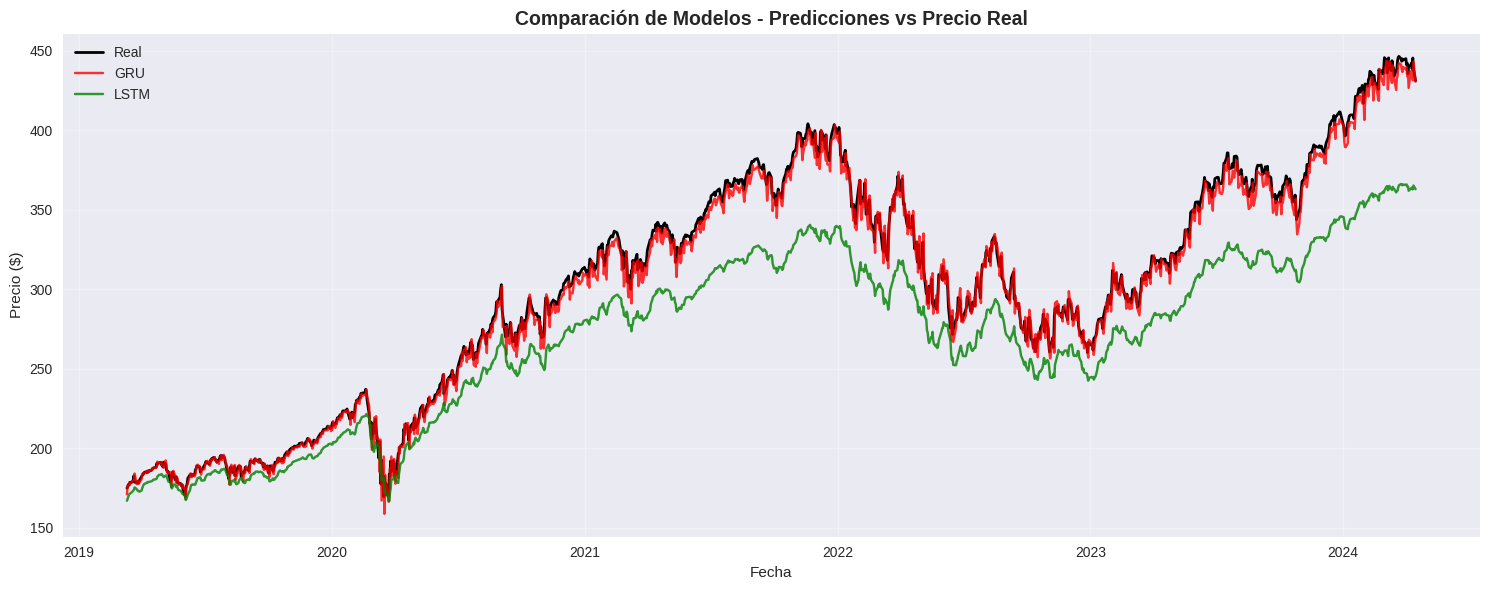

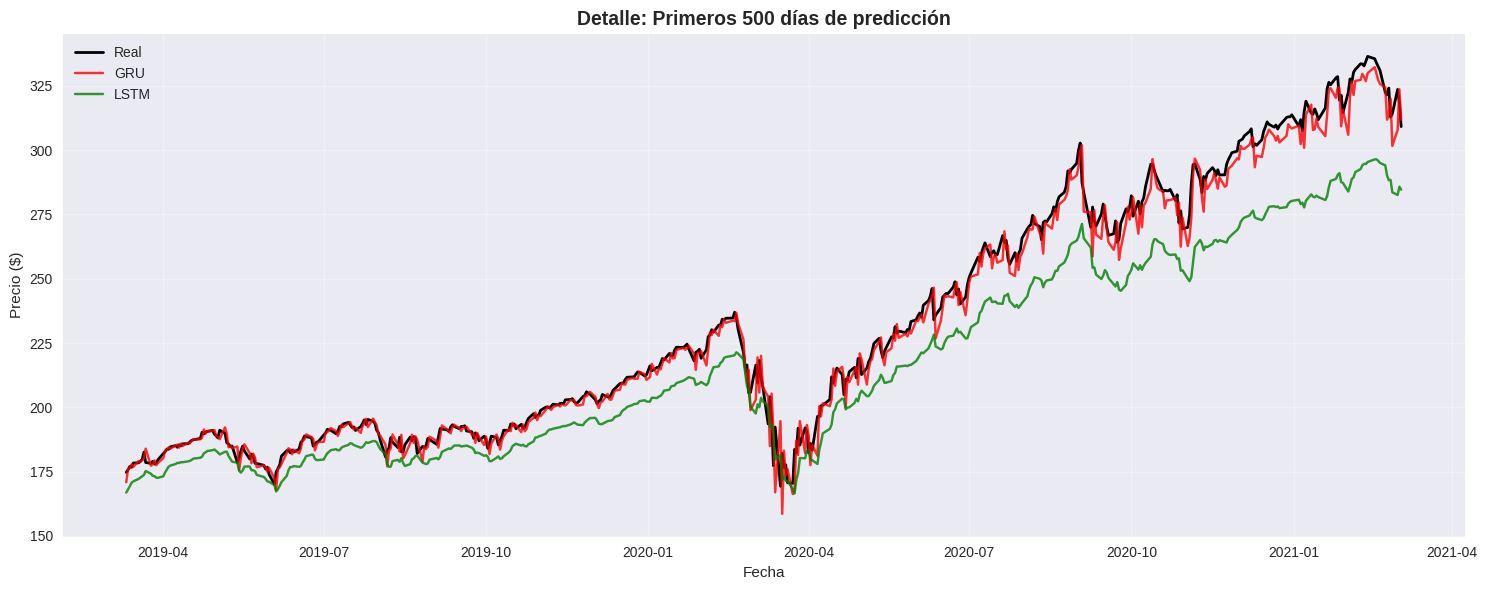

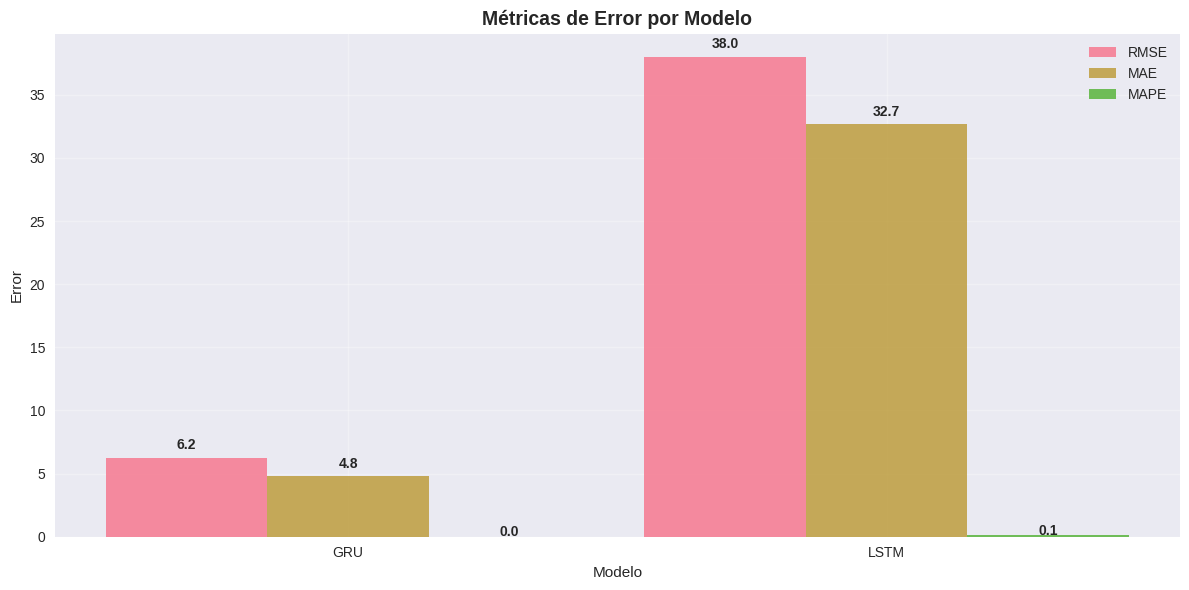

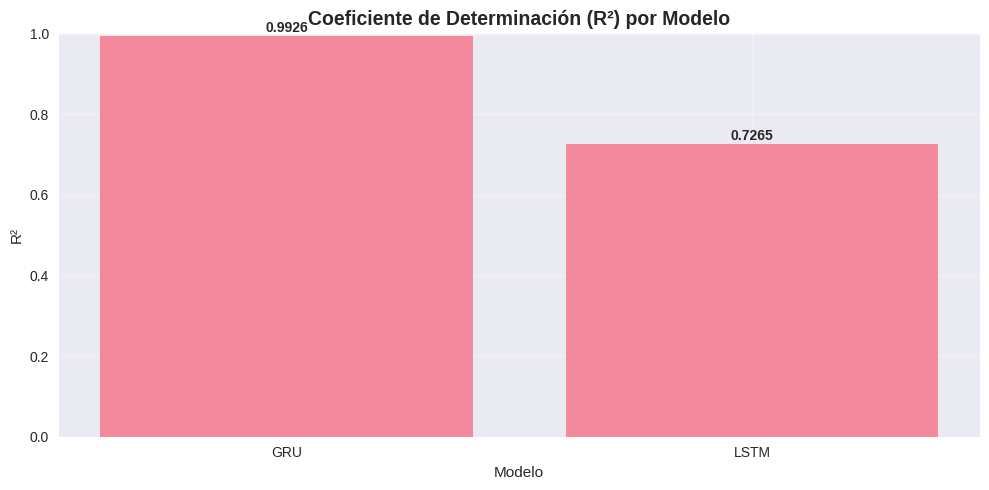

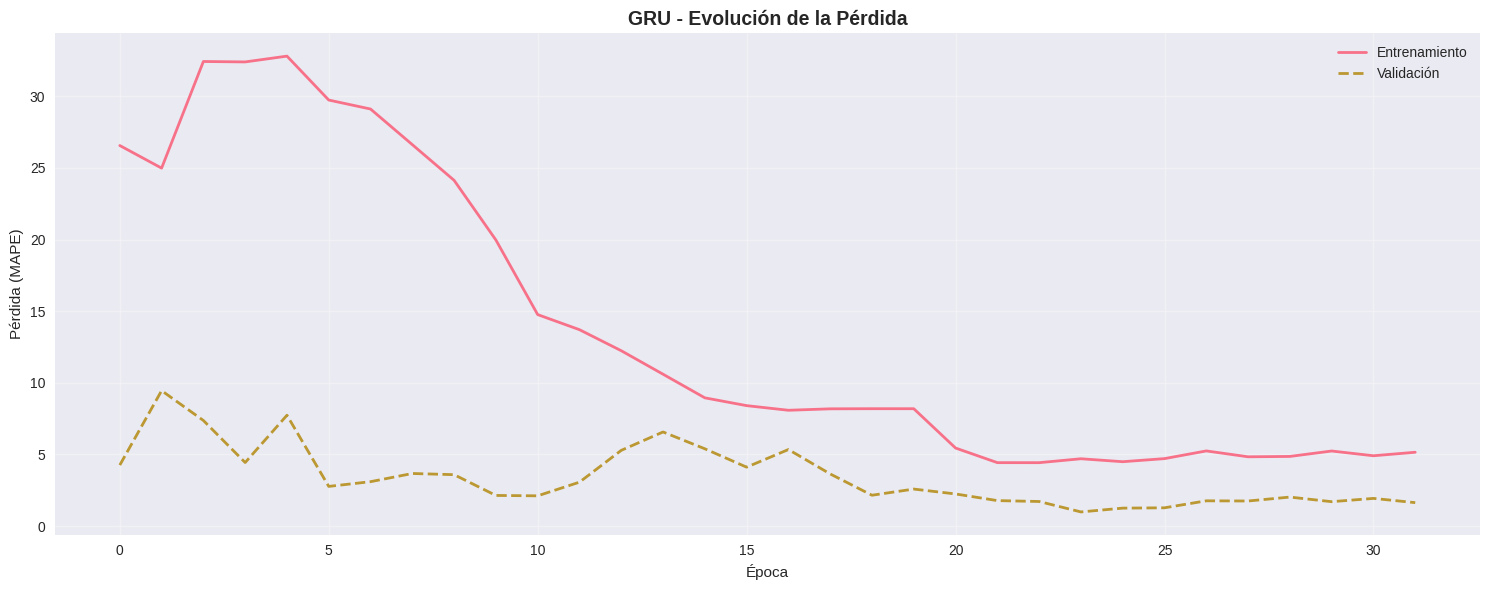

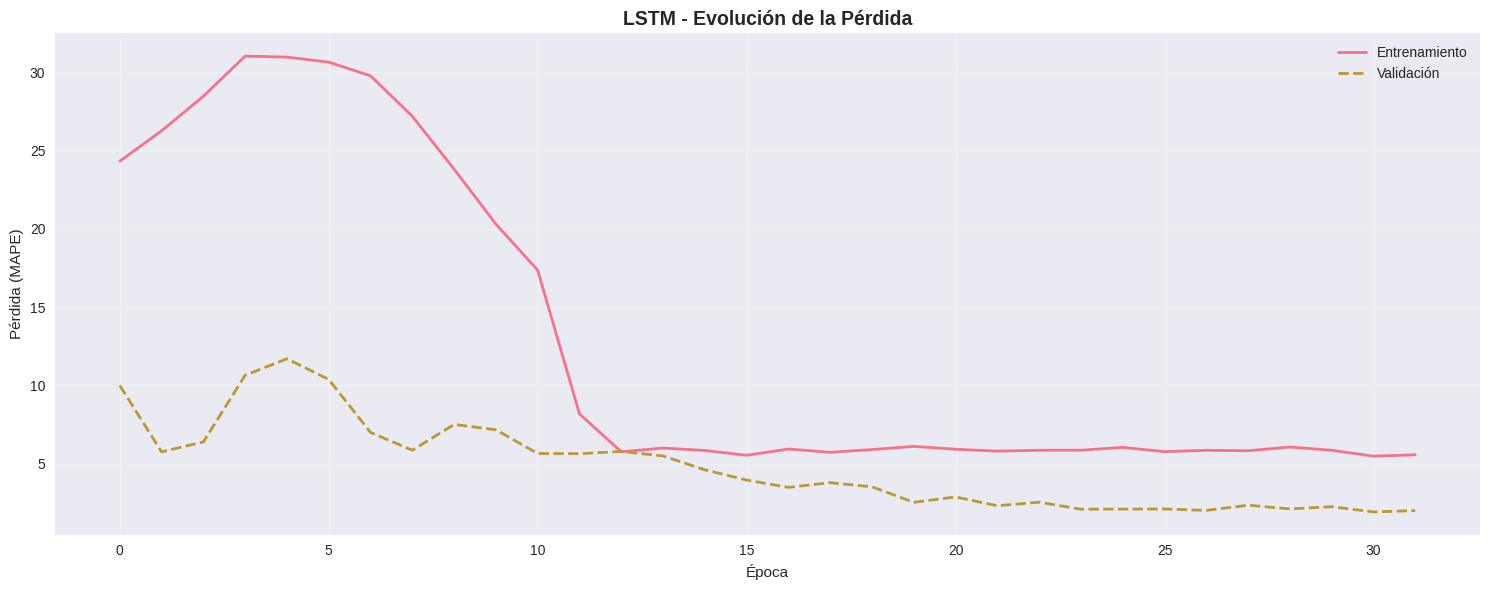


RESUMEN DE RENDIMIENTO
         GRU     LSTM
RMSE  6.2275  37.9612
MAE   4.7972  32.6930
MAPE  0.0159   0.0990
R²    0.9926   0.7265

🏆 Mejor RMSE: GRU (6.23)
🏆 Mejor R²: GRU (0.9926)

Entrenamiento: 5032 días (20 años)
Validación: 1284 días
Ventana temporal: 252 días


In [10]:
# Evaluación y Gráficas

actual_prices = test_data['close'].values
gru_metrics = calculate_metrics(actual_prices, gru_predictions.flatten(), "GRU")
lstm_metrics = calculate_metrics(actual_prices, lstm_predictions.flatten(), "LSTM")

# Variables para gráficos
models = ['GRU', 'LSTM']
colors = ['blue', 'green']
rmse_vals = [gru_metrics['RMSE'], lstm_metrics['RMSE']]
mae_vals = [gru_metrics['MAE'], lstm_metrics['MAE']]
mape_vals = [gru_metrics['MAPE'], lstm_metrics['MAPE']]
r2_vals = [gru_metrics['R2'], lstm_metrics['R2']]

# 1. Comparación completa
plt.figure(figsize=(15, 6))
plt.plot(test_data['date'], actual_prices, label='Real', color='black', linewidth=2)
plt.plot(test_data['date'], gru_predictions.flatten(), label='GRU', color='red', alpha=0.8)
plt.plot(test_data['date'], lstm_predictions.flatten(), label='LSTM', color='green', alpha=0.8)
plt.title('Comparación de Modelos - Predicciones vs Precio Real', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Detalle primeros N días (hasta 500)
n_zoom = min(500, len(test_data))
plt.figure(figsize=(15, 6))
plt.plot(test_data['date'][:n_zoom], actual_prices[:n_zoom], label='Real', color='black', linewidth=2)
plt.plot(test_data['date'][:n_zoom], gru_predictions[:n_zoom].flatten(), label='GRU', color='red', alpha=0.8)
plt.plot(test_data['date'][:n_zoom], lstm_predictions[:n_zoom].flatten(), label='LSTM', color='green', alpha=0.8)
plt.title(f'Detalle: Primeros {n_zoom} días de predicción', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Métricas comparativas (RMSE, MAE y MAPE)
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.3

plt.bar(x - width, rmse_vals, width, label='RMSE', alpha=0.8)
plt.bar(x,       mae_vals,  width, label='MAE',  alpha=0.8)
plt.bar(x + width, mape_vals, width, label='MAPE', alpha=0.8)

plt.title('Métricas de Error por Modelo', fontsize=14, fontweight='bold')
plt.xlabel('Modelo')
plt.ylabel('Error')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

for i, (rmse, mae, mape) in enumerate(zip(rmse_vals, mae_vals, mape_vals)):
    plt.text(i - width, rmse + max(rmse_vals) * 0.02, f'{rmse:.1f}', ha='center', fontweight='bold')
    plt.text(i,         mae  + max(mae_vals)  * 0.02, f'{mae:.1f}',  ha='center', fontweight='bold')
    plt.text(i + width, mape + max(mape_vals) * 0.02, f'{mape:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Coeficiente R²
plt.figure(figsize=(10, 5))
bars = plt.bar(models, r2_vals, alpha=0.8)
plt.title('Coeficiente de Determinación (R²) por Modelo', fontsize=14, fontweight='bold')
plt.xlabel('Modelo')
plt.ylabel('R²')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

for bar, r2 in zip(bars, r2_vals):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{r2:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Pérdidas durante entrenamiento - GRU
plt.figure(figsize=(15, 6))
plt.plot(gru_history.history['loss'], label='Entrenamiento', linewidth=2)
plt.plot(gru_history.history['val_loss'], label='Validación', linewidth=2, linestyle='--')
plt.title('GRU - Evolución de la Pérdida', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida (MAPE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Pérdidas durante entrenamiento - LSTM
plt.figure(figsize=(15, 6))
plt.plot(lstm_history.history['loss'], label='Entrenamiento', linewidth=2)
plt.plot(lstm_history.history['val_loss'], label='Validación', linewidth=2, linestyle='--')
plt.title('LSTM - Evolución de la Pérdida', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida (MAPE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN
# =============================================================================

print("\n" + "=" * 60)
print("RESUMEN DE RENDIMIENTO")
print("=" * 60)

comparison_df = pd.DataFrame({
    'GRU':  [gru_metrics['RMSE'],  gru_metrics['MAE'],  gru_metrics['MAPE'],  gru_metrics['R2']],
    'LSTM': [lstm_metrics['RMSE'], lstm_metrics['MAE'], lstm_metrics['MAPE'], lstm_metrics['R2']],
}, index=['RMSE', 'MAE', 'MAPE', 'R²'])

print(comparison_df.round(4))

# Mejor modelo
rmse_models = {'GRU': gru_metrics['RMSE'], 'LSTM': lstm_metrics['RMSE']}
r2_models   = {'GRU': gru_metrics['R2'],   'LSTM': lstm_metrics['R2']}

best_rmse_model = min(rmse_models, key=rmse_models.get)
best_r2_model   = max(r2_models,   key=r2_models.get)

print(f"\n🏆 Mejor RMSE: {best_rmse_model} ({rmse_models[best_rmse_model]:.2f})")
print(f"🏆 Mejor R²: {best_r2_model} ({r2_models[best_r2_model]:.4f})")

print(f"\nEntrenamiento: {len(train_data)} días (20 años)")
print(f"Validación: {len(test_data)} días")
print(f"Ventana temporal: {WINDOW_SIZE} días")
